In [71]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt 

import  matplotlib.pyplot as plt 

In [72]:
def option_chains(ticker):
    asset = yf.Ticker(ticker)
    expirations = asset.options

    chains = pd.DataFrame()

    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(expiration)

        calls = opt.calls
        calls['optionType'] = "call"

        puts = opt.puts
        puts['optionType'] = "put"

        chain = pd.concat([calls, puts])
        chain['expiration'] = (
            pd.to_datetime(expiration) + 
            pd.DateOffset(hours=23, minutes=59, seconds=59)
        )

        chains = pd.concat([chains, chain])

    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1 
    
    return chains

In [73]:
options = option_chains("SPY")
calls = options[options["optionType"] == "call"]


<AxesSubplot:title={'center':'Implied Volatility Skew'}, xlabel='strike'>

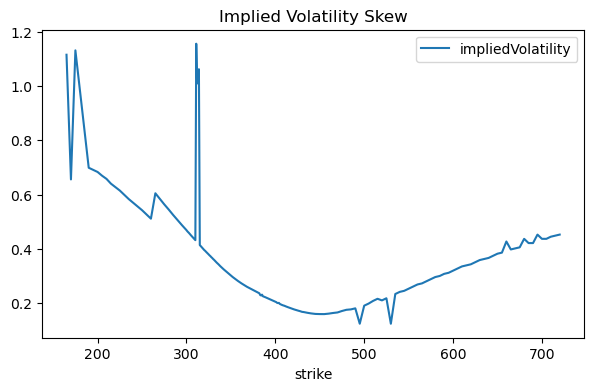

In [74]:
#select an expiration to plot 
calls_at_expiry = calls[calls["expiration"] == "2023-01-20 23:59:59"]

#filtered out low vols
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]

#set the strike as the index so pandas plots nicely
filtered_calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(
    title="Implied Volatility Skew", figsize=(7,4)
    )


<AxesSubplot:title={'center':'Implied Volatility Term Structure'}, xlabel='expiration'>

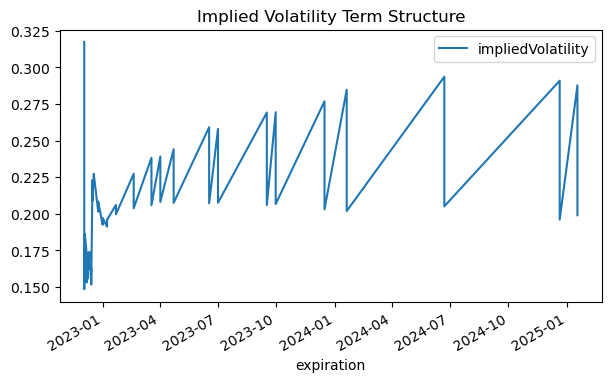

In [75]:
# select an expiration to plot 
calls_at_strike = options[options["strike"] == 400.0]

#filter out lows vols
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]

#set the strike as the index so pandas plot nicely
filtered_calls_at_strike [["expiration", "impliedVolatility"]].set_index("expiration").plot(
    title="Implied Volatility Term Structure", figsize=(7,4)
)

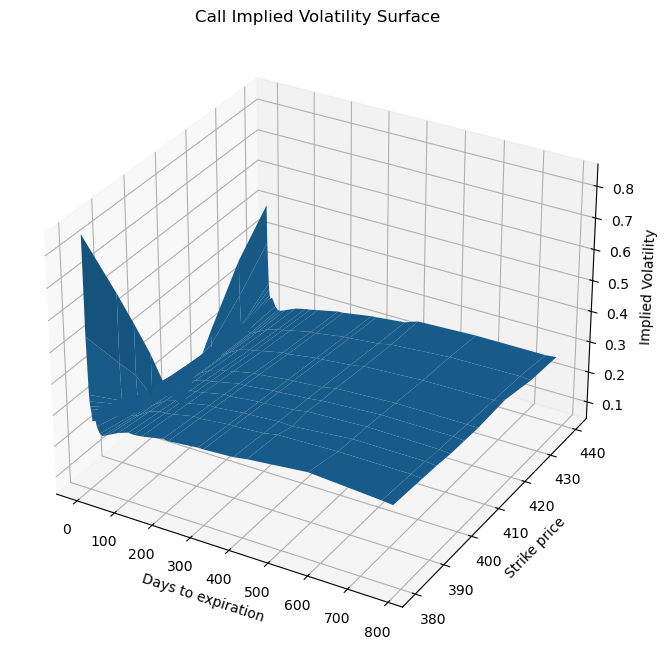

In [76]:
#pivot the dataframe
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

#create the figure object 
fig = plt.figure(figsize=(10, 8))

#add  the subplot with projection argument 
ax = fig.add_subplot(111, projection='3d')

#get the 1d values from the pivoted dataframe 
x, y, z = surface.columns.values, surface.index.values, surface.values

#return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

#set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied Volatility')
ax.set_title('Call Implied Volatility Surface')

#plot
ax.plot_surface(X, Y, z)